In [7]:
"""
Analysis pipeline on BERT models

BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding
https://arxiv.org/abs/1810.04805

BERT is multi-layer bidirectional Transformer encoder based on the original implementation described in Vaswani et al. (2017)
"""

import numpy as np
import matplotlib.pyplot as plt

from transformers import BertModel

In [8]:
'import BERT base model (l = 12, d = 768, h = 12 ; tot num parameters 110M)'

l = 12
d = 768
h = 12

dh = d // h

model = BertModel.from_pretrained("bert-base-uncased")

In [9]:
"""
get Wq and Wk matrices and compute the pseudo-quadratic-form M = Wq@Wk^T
returns:
- Wq (list): query projection matrix for each layer
- Wk (list): key projection matrix for each layer
- Wv (list): value projection matrix for each layer
- M (list): inner product matrix for each layer
"""

def get_matrices(model):

    layers = len(model.encoder.layer)    
    Wq, Wk, Wv, M = [], [], [], []
    for l in range(layers):
        Wq.append(model.encoder.layer[l].attention.self.query.weight.detach().numpy())
        Wk.append(model.encoder.layer[l].attention.self.key.weight.detach().numpy())
        Wv.append(model.encoder.layer[l].attention.self.value.weight.detach().numpy())
        M.append(Wq[l]@(Wk[l].T))        

    return Wq, Wk, Wv, M

Wq, Wk, Wv, M = get_matrices(model)

In [10]:
"""
Hypothesis 1: the diagonal block of M are almost symmetric.

We calculate the frobenious norm of the symmetric and skew-symmetric component of M. 
The only significant part of M as a quadratic form is its symmetric component.

We define an asymmetry index for a given matrix A as the Frobenius norm of (A - A^T),
normalized by the max entry of A, quantifying the asymmetry relative to its largest scale.

(A symmetric matrix would have and index of 0, and how to interpret the relative deviation
from this lower-bound depends on the context.)
"""

def decomposition_syn_asyn(A):
    
    asyn_part = np.linalg.norm(.5 * (A - A.T), 'fro') / np.linalg.norm(A, 'fro')
    syn_part = np.linalg.norm(.5 * (A + A.T), 'fro') / np.linalg.norm(A, 'fro')

    return syn_part, asyn_part

def decomposition_blocks(h,dh,A):
    scoresyn = np.zeros(h)
    scoreasyn = np.zeros(h)
    for head in range(h):

        scoresyn[head], scoreasyn[head] = decomposition_syn_asyn(A[head:head+dh,
                                                                   head:head+dh])
    return scoresyn, scoreasyn

In [11]:

layer = 0

scoresyn_M, scoreasyn_M = decomposition_blocks(h,dh,M[layer])
scoresyn_Wq, scoreasyn_Wq = decomposition_blocks(h,dh,Wq[layer])
scoresyn_Wk, scoreasyn_Wk = decomposition_blocks(h,dh,Wk[layer])

## random uniform matrix
Mr = np.random.uniform(M[layer].min(),M[layer].max(),M[layer].shape)
scoresyn_Mr, scoreasyn_Mr = decomposition_blocks(h,dh,Mr)

## currupted identity matrices
a1 = .5
a2 = .01
Ir1 = np.eye(d) + a1 * np.random.uniform(0,1,M[layer].shape)
Ir2 = np.eye(d) + a2 * np.random.uniform(0,1,M[layer].shape)
scoresyn_Ir1, scoreasyn_Ir1 = decomposition_blocks(h,dh,Ir1)
scoresyn_Ir2, scoreasyn_Ir2 = decomposition_blocks(h,dh,Ir2)

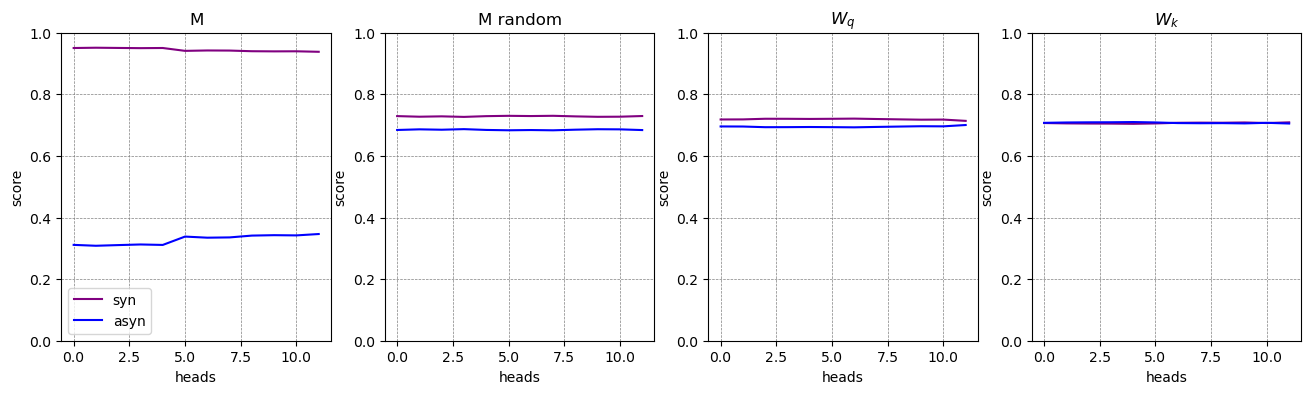

In [12]:

## plot
plt.figure(figsize=(16,4))

plt.subplot(1,4,1)
plt.title('M')
plt.plot(scoresyn_M,color='purple',label='syn')
plt.plot(scoreasyn_M,color='blue',label='asyn')
plt.xlabel('heads')
plt.ylabel('score')
plt.ylim(0,1)
plt.legend()
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)

plt.subplot(1,4,2)
plt.title('M random')
plt.plot(scoresyn_Mr,color='purple',label='syn')
plt.plot(scoreasyn_Mr,color='blue',label='asyn')
plt.xlabel('heads')
plt.ylabel('score')
plt.ylim(0,1)
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)

plt.subplot(1,4,3)
plt.title(r'$W_q$')
plt.plot(scoresyn_Wq,color='purple',label='syn')
plt.plot(scoreasyn_Wq,color='blue',label='asyn')
plt.xlabel('heads')
plt.ylabel('score')
plt.ylim(0,1)
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)

plt.subplot(1,4,4)
plt.title(r'$W_k$')
plt.plot(scoresyn_Wk,color='purple',label='syn')
plt.plot(scoreasyn_Wk,color='blue',label='asyn')
plt.xlabel('heads')
plt.ylabel('score')
plt.ylim(0,1)
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)

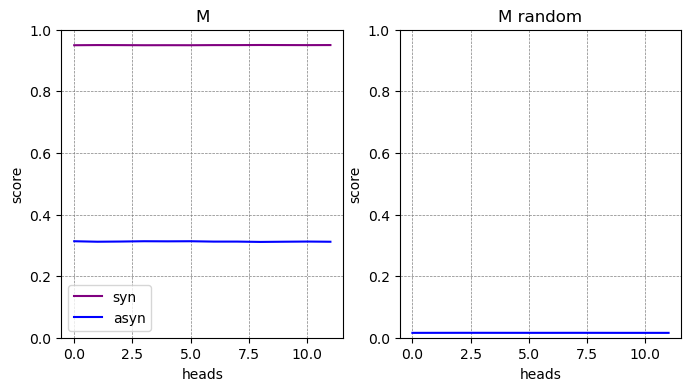

In [13]:
plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
plt.title('M')
plt.plot(scoresyn_Ir1,color='purple',label='syn')
plt.plot(scoreasyn_Ir1,color='blue',label='asyn')
plt.xlabel('heads')
plt.ylabel('score')
plt.ylim(0,1)
plt.legend()
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)

plt.subplot(1,2,2)
plt.title('M random')
plt.plot(scoresyn_Ir2,color='purple',label='syn')
plt.plot(scoreasyn_Ir2,color='blue',label='asyn')
plt.xlabel('heads')
plt.ylabel('score')
plt.ylim(0,1)
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)

In [74]:
def get_components(A):
    S = .5 * (A + A.T)
    N = .5 * (A - A.T)
    return S, N

def get_blocks(h,dh,A):
    SList = []
    NList = []
    for head in range(h):
        S, N = get_components(A[ head:head+dh, head:head+dh ])
        SList.append(S)
        NList.append(N)
    return SList, NList

def eigen_blocks(h,dh,A):
    eigenvalues = []
    for j in range(h):
        eigenvalues.append(np.linalg.eigvals(A[ j:j+dh , j:j+dh ]))
    return eigenvalues

layer = 6
S, N = get_blocks(h,dh,M[layer])
eigenvalues = eigen_blocks(h,dh,S[layer])

Text(0, 0.5, 'values')

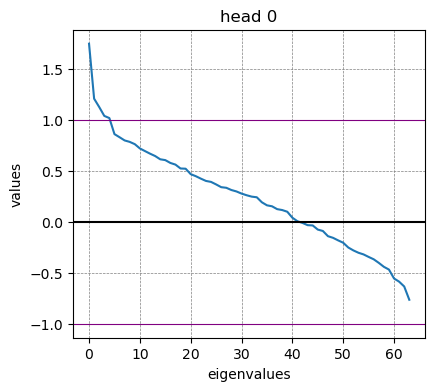

In [75]:
'eigenvalue distribution on the unit circle for a given head'
head = 0

# plot
plt.figure(figsize=(10,4))

plt.subplot(1,2,2)
plt.title('head '+str(head))
plt.plot(np.sort(eigenvalues[head])[::-1])
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
plt.axhline(y=0,color='k')
plt.axhline(y=1,color='purple',linewidth=.8)
plt.axhline(y=-1,color='purple',linewidth=.8)
plt.xlabel('eigenvalues')
plt.ylabel('values')

In [77]:
"""
eigenvalues distribution across the network layers

We quantify how the percentage of leading eigenvalues (with magnitude > 1) changes across layers,
and how many eigenvalues are either real or complex conjugates
"""

eigenlead_pos = np.zeros((h,l))
eigenlead_neg = np.zeros((h,l))
eigenmax_pos = np.zeros((h,l))
eigenmax_neg = np.zeros((h,l))

for layer in range(l):
    S, N = get_blocks(h,dh,M[layer])
    eigenvalues = eigen_blocks(h,dh,S[layer]) 

    for head in range(h): 
        eigenlead_pos[head,layer] = np.sum(eigenvalues[head] > 1)
        eigenmax_pos[head,layer] = eigenvalues[head].max()
        eigenlead_neg[head,layer] = np.sum(eigenvalues[head] < -1)
        eigenmax_neg[head,layer] = eigenvalues[head].min()
        
eigenlead_pos = eigenlead_pos / dh
eigenlead_neg = eigenlead_neg / dh

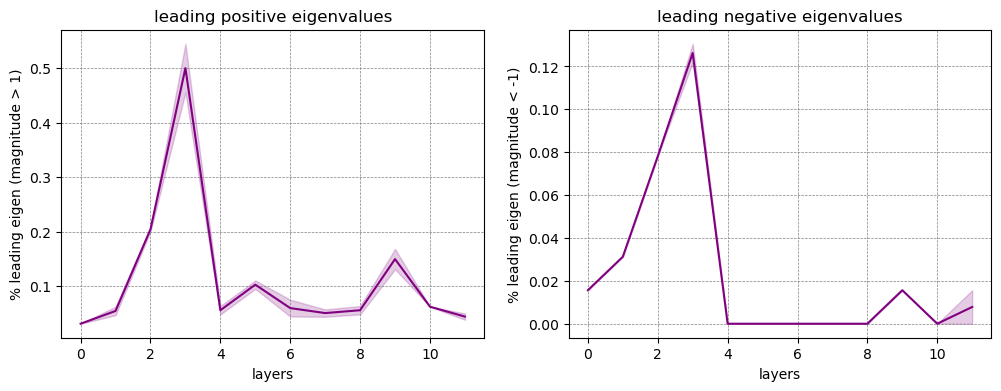

In [78]:
'plots'
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(eigenlead_pos.mean(axis=0),c='purple')
plt.fill_between(range(l),
                 eigenlead_pos.mean(axis=0) + eigenlead_pos.std(axis=0),
                 eigenlead_pos.mean(axis=0) - eigenlead_pos.std(axis=0),
                 color='purple',
                 alpha=.2)
plt.title('leading positive eigenvalues')
plt.xlabel('layers')
plt.ylabel('% leading eigen (magnitude > 1)')
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)

plt.subplot(1,2,2)
plt.plot(eigenlead_neg.mean(axis=0),c='purple')
plt.fill_between(range(l),
                 eigenlead_neg.mean(axis=0) + eigenlead_neg.std(axis=0),
                 eigenlead_neg.mean(axis=0) - eigenlead_neg.std(axis=0),
                 color='purple',
                 alpha=.2)
plt.title('leading negative eigenvalues')
plt.xlabel('layers')
plt.ylabel('% leading eigen (magnitude < -1)')
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)

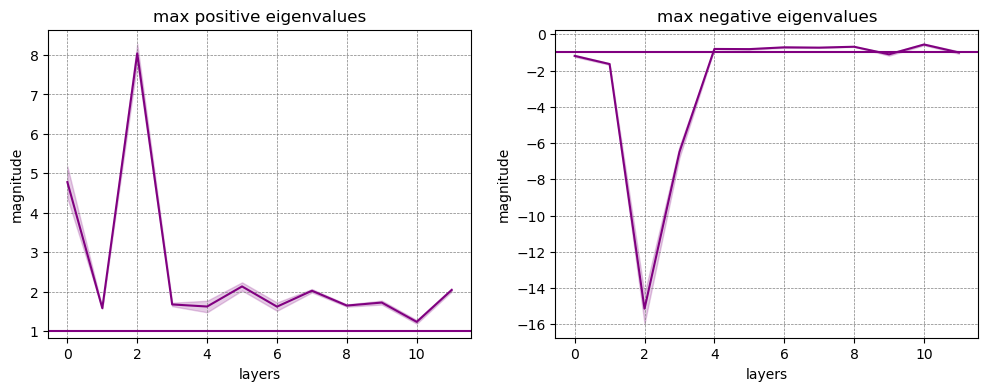

In [81]:
'plots'
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(eigenmax_pos.mean(axis=0),c='purple')
plt.fill_between(range(l),
                 eigenmax_pos.mean(axis=0) + eigenmax_pos.std(axis=0),
                 eigenmax_pos.mean(axis=0) - eigenmax_pos.std(axis=0),
                 color='purple',
                 alpha=.2)
plt.title('max positive eigenvalues')
plt.xlabel('layers')
plt.ylabel('magnitude')
plt.axhline(y=1,color='purple')
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)

plt.subplot(1,2,2)
plt.plot(eigenmax_neg.mean(axis=0),c='purple')
plt.fill_between(range(l),
                 eigenmax_neg.mean(axis=0) + eigenmax_neg.std(axis=0),
                 eigenmax_neg.mean(axis=0) - eigenmax_neg.std(axis=0),
                 color='purple',
                 alpha=.2)
plt.title('max negative eigenvalues')
plt.xlabel('layers')
plt.ylabel('magnitude')
plt.axhline(y=-1,color='purple')
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)